# Zählen von Zellkernen in Kacheln

In diesem Notebook werden wir einen großen Datensatz verarbeiten, der im Zarr-Format gespeichert wurde, um Zellen in einzelnen Kacheln zu zählen. Für jede Kachel werden wir einen Pixel in ein Ausgabebild schreiben. Somit erzeugen wir ein Zellzählungsbild, das um einen Faktor kleiner ist als das Originalbild, der der Kachelgröße entspricht.

In [1]:
import zarr
import dask.array as da
import numpy as np
from skimage.io import imread
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow
from numcodecs import Blosc

Zu Demonstrationszwecken verwenden wir einen Datensatz, der von Theresa Suckert, OncoRay, Universitätsklinikum Carl Gustav Carus, TU Dresden, zur Verfügung gestellt wurde. Der Datensatz ist unter der [Lizenz: CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) lizenziert. Wir verwenden hier eine zugeschnittene Version, die als 8-Bit-Bild neu gespeichert wurde, um sie mit dem Notebook bereitstellen zu können. Das vollständige 16-Bit-Bild im CZI-Dateiformat finden Sie [online](https://zenodo.org/record/4276076#.YX1F-55BxaQ).

In [2]:
image = imread('../../data/P1_H_C3H_M004_17-cropped.tif')[1]

# for testing purposes, we crop the image even more.
# comment out the following line to run on the whole 5000x2000 pixels
image = image[1000:1500, 1000:1500]

#compress AND change the numpy array into a zarr array
compressor = Blosc(cname='zstd', clevel=3, shuffle=Blosc.BITSHUFFLE)

# Convert image into zarr array
chunk_size = (100, 100)
zarray = zarr.array(image, chunks=chunk_size, compressor=compressor)

# save zarr to disk
zarr_filename = '../../data/P1_H_C3H_M004_17-cropped.zarr'
zarr.convenience.save(zarr_filename, zarray)

## Laden des zarr-basierten Bildes
Dask bietet integrierte Unterstützung für das Zarr-Dateiformat. Wir können Dask-Arrays direkt aus einer Zarr-Datei erstellen.

In [3]:
zarr_image = da.from_zarr(zarr_filename)
zarr_image

dask.array<from-zarr, shape=(500, 500), dtype=uint8, chunksize=(100, 100), chunktype=numpy.ndarray>

Wir können die Bildverarbeitung direkt auf diesen gekachelten Datensatz anwenden.

## Zählen von Zellkernen
Um die Zellkerne zu zählen, richten wir einen einfachen Bildverarbeitungs-Workflow ein, der Voronoi-Otsu-Labeling auf den Datensatz anwendet. Anschließend zählen wir die segmentierten Objekte. Da Zellkerne, die die Kachelgrenze berühren, möglicherweise doppelt gezählt werden, müssen wir die Zählung für jede Kachel korrigieren. Technisch gesehen könnten wir die Objekte entfernen, die eine der vertikalen oder horizontalen Kachelgrenzen berühren. Es gibt jedoch einen einfacheren Weg, diesen Fehler zu korrigieren: Wir zählen die Anzahl der Zellkerne nach der Segmentierung. Dann entfernen wir alle Zellkerne, die einen Bildrand berühren, und zählen die verbleibenden Zellkerne erneut. Wir können dann davon ausgehen, dass die Hälfte der entfernten Zellkerne gezählt werden sollte. Daher addieren wir die beiden Zählungen vor und nach der Randentfernung und berechnen den Durchschnitt dieser beiden Messungen. Besonders bei großen Kacheln mit vielen Zellkernen sollte der verbleibende Fehler vernachlässigbar sein. Es wird nicht empfohlen, eine solche schätzende Zellzählmethode anzuwenden, wenn jede Kachel nur wenige Zellkerne enthält.

In [4]:
def count_nuclei(image):
    """
    Label objects in a binary image and produce a pixel-count-map image.
    """
    print("Processing image of size", image.shape)
    
    # Count nuclei including those which touch the image border
    labels = cle.voronoi_otsu_labeling(image, spot_sigma=3.5)
    label_intensity_map = cle.mean_intensity_map(image, labels)
    
    high_intensity_labels = cle.exclude_labels_with_map_values_within_range(label_intensity_map, labels, maximum_value_range=20)
    nuclei_count = high_intensity_labels.max()
    
    # Count nuclei including those which touch the image border
    labels_without_borders = cle.exclude_labels_on_edges(high_intensity_labels)
    nuclei_count_excluding_borders = labels_without_borders.max()
    
    # Both nuclei-count including and excluding nuclei at image borders 
    # are no good approximation. We should exclude the nuclei only on 
    # half of the borders to get a good estimate.
    # Alternatively, we just take the average of both counts.
    result = np.asarray([[(nuclei_count + nuclei_count_excluding_borders) / 2]])
    
    print(result.shape)
    
    return result

Bevor wir mit der Berechnung beginnen können, müssen wir die asynchrone Ausführung von Operationen in pyclesperanto deaktivieren. [Siehe auch das zugehörige Problem](https://github.com/clEsperanto/pyclesperanto_prototype/issues/163).

In [5]:
cle.set_wait_for_kernel_finish(True)

Diesmal verwenden wir keine Kachelüberlappung, da wir keine Eigenschaften der Zellkerne messen und daher keine perfekte Segmentierung benötigen.

In [6]:
tile_map = da.map_blocks(count_nuclei, zarr_image)

tile_map

Processing image of size (0, 0)
Processing image of size (1, 1)
(1, 1)
Processing image of size (0, 0)


dask.array<count_nuclei, shape=(500, 500), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

Da das Ergebnisbild viel kleiner ist als das Original, können wir die gesamte Ergebniskarte berechnen.

In [7]:
result = tile_map.compute()

Processing image of size (100, 100)
Processing image of sizeProcessing image of size (100, 100)
Processing image of size (100, 100)
 (100, 100)
Processing image of size (100, 100)
Processing image of size (100, 100)
Processing image of sizeProcessing image of size (100, 100)
 Processing image of size(100, 100)
 (100, 100)
Processing image of size (100, 100)
(1, 1)
(1, 1)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
Processing image of size (100, 100)
(1, 1)(1, 1)

Processing image of size (100, 100)
Processing image of size(1, 1)
 (100, 100)
Processing image of size (100, 100)
(1, 1)
(1, 1)
Processing image of size (100, 100)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
(1, 1)
Processing image of size (100, 100)
(1, 1)
(1, 1)
Processing image of sizeProcessing image of size  (100, 100)
(100, 100)
(1, 1)(1, 1)

(1, 1)
Processing image of size Processing image of size(100, 100) 

In [8]:
result.shape

(5, 5)

Da die Ergebniskarte klein ist, können wir sie einfach visualisieren.

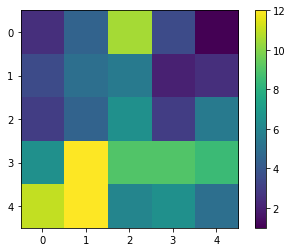

In [9]:
cle.imshow(result, colorbar=True)

Mit einer schnellen visuellen Überprüfung im Originalbild können wir sehen, dass in der unteren linken Ecke des Bildes tatsächlich mehr Zellen sind als in der oberen rechten.

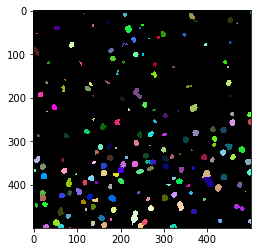

In [10]:
cle.imshow(cle.voronoi_otsu_labeling(image, spot_sigma=3.5), labels=True)